# Label Concurrency Analysis

This notebook analyzes the concurrency of labels generated by different labeling strategies.
Label concurrency refers to the number of active labels at any given point in time.
High concurrency can be an issue for model training as it implies that the training samples
are not independent. This analysis helps in understanding and comparing how different
labeling techniques (fixed-time horizon, volatility-adjusted, triple-barrier) affect
the overlap of training examples.

In [1]:
import sys
import os
current_dir = os.getcwd()
# Navigate up one level to the project root (e.g., /path/to/my_project)
project_root = os.path.abspath(os.path.join(current_dir, '../src'))
# Add the project root to sys.path so Python can find 'src' as a top-level package
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# This try-except block allows the script to be run from the project root or from the `data_analysis` directory.
try:
    from src.data_analysis.data_analysis import fetch_historical_data, adjust_data_to_ubtc
    from src.data_analysis.bar_aggregation import create_dollar_bars, create_volume_bars
    from src.data_analysis.labeling import (
        create_fixed_time_horizon_labels,
        create_volatility_adjusted_labels,
        create_triple_barrier_labels,
    )
    from src.data_analysis.sampling import count_concurrent_labels
except ModuleNotFoundError:
    # If `src` is not in the path, add the project root. This assumes the script is in `data_analysis`.
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    from src.data_analysis.data_analysis import fetch_historical_data, adjust_data_to_ubtc
    from src.data_analysis.bar_aggregation import create_dollar_bars, create_volume_bars
    from src.data_analysis.labeling import (
        create_fixed_time_horizon_labels,
        create_volatility_adjusted_labels,
        create_triple_barrier_labels,
    )
    from src.data_analysis.sampling import count_concurrent_labels

sns.set_style("whitegrid")

## 1. Load Data

We load historical BTC/USDT daily data for our analysis.

In [4]:
DATA_PATH = '/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/data/binance/python/data/spot/daily/klines/BTCUSDT/1h/BTCUSDT_consolidated_klines.csv'
START_DATE = "2020-01-01"
data = fetch_historical_data(data_path=DATA_PATH, start_date=START_DATE, timeframe="1d")
data = adjust_data_to_ubtc(data)
data.dropna(inplace=True)
close = data["Close"]
# Common parameters
LOOK_FORWARD = 5  # 20 days
VOL_WINDOW = 30    # 20-day rolling volatility

print(f"Data loaded from {data.index.min()} to {data.index.max()}")
print(f"Number of data points: {len(data)}")

Data loaded from 2020-01-01 00:00:00 to 2025-11-07 23:00:00
Number of data points: 51280


## 2. Generate Labels using Different Strategies

We will generate labels using three different methods to compare their concurrency properties.

In [14]:

# --- Strategy 1: Fixed-Time Horizon Labels ---
print("Generating Fixed-Time Horizon Labels...")
fixed_labels_df = create_fixed_time_horizon_labels(
    close=close,
    look_forward=LOOK_FORWARD,
    pt_pct=0.05,  # 5% profit take
    sl_pct=0.05,  # 5% stop loss
)
print(f"Generated {len(fixed_labels_df)} labels.")

# --- Strategy 2: Volatility-Adjusted Labels ---
print("\nGenerating Volatility-Adjusted Labels...")
vol_adjusted_labels_df = create_volatility_adjusted_labels(
    close=close,
    look_forward=LOOK_FORWARD,
    vol_window=VOL_WINDOW,
    vol_multiplier=1.5,  # Thresholds at 1.5x sigma
)
print(f"Generated {len(vol_adjusted_labels_df)} labels.")

# --- Strategy 3: Triple-Barrier Labels ---
print("\nGenerating Triple-Barrier Labels...")
# Calculate volatility for the triple-barrier method
volatility = close.pct_change().rolling(window=VOL_WINDOW).std()
triple_barrier_labels_df = create_triple_barrier_labels(
    close=close,
    volatility=volatility,
    look_forward=31,
    pt_sl_multipliers=(2.0, 2.0),  # Profit/Stop at 2x sigma
    label_timeout_by_sign=True,
)
print(f"Generated {len(triple_barrier_labels_df)} labels.")

Generating Fixed-Time Horizon Labels...
Generated 51275 labels.

Generating Volatility-Adjusted Labels...
Generated 51275 labels.

Generating Triple-Barrier Labels...


/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/src/data_analysis/labeling.py:148: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  volatility = volatility.reindex(close.index).fillna(method="ffill")


Generated 51219 labels.


## 3. Compute Label Concurrency

Now we use the `count_concurrent_labels` function to determine the number of active
labels at each timestamp for each labeling strategy.

In [17]:
print("Computing concurrency for each labeling strategy...")

# Concurrency for Fixed-Time Horizon labels
concurrency_fixed = count_concurrent_labels(
    event_end_times=fixed_labels_df["event_end_time"],
    price_series_index=close.index,
)

# Concurrency for Volatility-Adjusted labels
concurrency_vol_adjusted = count_concurrent_labels(
    event_end_times=vol_adjusted_labels_df["event_end_time"],
    price_series_index=close.index,
)

# Concurrency for Triple-Barrier labels
concurrency_triple_barrier = count_concurrent_labels(
    event_end_times=triple_barrier_labels_df["event_end_time"],
    price_series_index=close.index,
)

print("\nConcurrency Statistics:")
concurrency_stats = pd.DataFrame({
    "Fixed-Time Horizon": concurrency_fixed.describe(),
    "Volatility-Adjusted": concurrency_vol_adjusted.describe(),
    "Triple-Barrier": concurrency_triple_barrier.describe(),
})
print(concurrency_stats)

Computing concurrency for each labeling strategy...


ValueError: cannot reindex on an axis with duplicate labels

## 4. Visualize and Analyze Concurrency

We plot the concurrency over time for each method. This visualization helps to
intuitively grasp how the label overlap differs between strategies.

- **Fixed-Time Horizon**: We expect a constant concurrency of `look_forward` because every
  event has the same fixed duration.
- **Volatility-Adjusted**: Similar to fixed-time, as the duration is also fixed.
- **Triple-Barrier**: We expect variable concurrency, as the duration of each event
  depends on when a barrier is hit. This should lead to lower average concurrency
  compared to fixed-horizon methods.

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

# Plot 1: Close Price
axes[0].plot(close, label="BTC/USDT Close Price", color="black")
axes[0].set_title("BTC/USDT Close Price", fontsize=16)
axes[0].set_ylabel("Price")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Fixed-Time Horizon Concurrency
axes[1].plot(concurrency_fixed, label="Fixed-Time Horizon", color="blue")
axes[1].set_title("Concurrency: Fixed-Time Horizon Labels", fontsize=16)
axes[1].set_ylabel("Number of Concurrent Labels")
axes[1].legend()
axes[1].grid(True)

# Plot 3: Volatility-Adjusted Concurrency
axes[2].plot(concurrency_vol_adjusted, label="Volatility-Adjusted", color="green")
axes[2].set_title("Concurrency: Volatility-Adjusted Labels", fontsize=16)
axes[2].set_ylabel("Number of Concurrent Labels")
axes[2].legend()
axes[2].grid(True)

# Plot 4: Triple-Barrier Concurrency
axes[3].plot(concurrency_triple_barrier, label="Triple-Barrier", color="red")
axes[3].set_title("Concurrency: Triple-Barrier Labels", fontsize=16)
axes[3].set_ylabel("Number of Concurrent Labels")
axes[3].set_xlabel("Date")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

### Analysis

As expected, the fixed-horizon methods show a constant level of concurrency, equal to the `look_forward` parameter. This is because every label spans the same number of time steps.

The triple-barrier method, on the other hand, shows fluctuating concurrency. This is because events can terminate early if a profit-take or stop-loss barrier is hit. This dynamic event duration leads to a lower and more variable number of overlapping labels, which is generally a desirable property for training machine learning models as it reduces the redundancy of information across samples.

## 5. Triple-Barrier Labels on Alternative Bars

We extend the analysis to Triple-Barrier labels applied on Dollar Bars and Volume Bars.
Alternative bars sample data based on activity (volume/dollars) rather than time, which
can lead to better statistical properties and different concurrency patterns.

Parameters:
- Dollar Bar Threshold: 1,000,000,000 (1e9) USDT
- Volume Bar Threshold: 50,000 BTC

In [18]:
print("\n--- Generating Alternative Bars and Labels ---")

# 1. Create Bars
# We assume data loaded via fetch_historical_data has 'Volume USDT' if present in CSV.

dollar_threshold = 1_000_000_000
volume_threshold = 50_000

print(f"Creating Dollar Bars (Thresh={dollar_threshold:,.0f})...")
dollar_bars = create_dollar_bars(data, dollar_threshold)
print(f"Created {len(dollar_bars)} Dollar Bars.")

print(f"Creating Volume Bars (Thresh={volume_threshold:,.0f})...")
volume_bars = create_volume_bars(data, volume_threshold)
print(f"Created {len(volume_bars)} Volume Bars.")

# 2. Generate Labels (Triple-Barrier)
def get_tb_labels(bars, name):
    if bars.empty:
        print(f"No bars created for {name}.")
        return pd.DataFrame(), pd.Series()
    
    # Recalculate volatility on these bars
    vol = bars["Close"].pct_change().rolling(window=VOL_WINDOW).std()
    
    labels = create_triple_barrier_labels(
        close=bars["Close"],
        volatility=vol,
        look_forward=8, 
        pt_sl_multipliers=(1, 1),
        label_timeout_by_sign=False,
    )
    return labels, bars["Close"]

print("Generating labels for Dollar Bars...")
dollar_labels, dollar_close = get_tb_labels(dollar_bars, "Dollar Bars")

print("Generating labels for Volume Bars...")
volume_labels, volume_close = get_tb_labels(volume_bars, "Volume Bars")




--- Generating Alternative Bars and Labels ---
Creating Dollar Bars (Thresh=1,000,000,000)...
Created 4590 Dollar Bars.
Creating Volume Bars (Thresh=50,000)...
Created 2956 Volume Bars.
Generating labels for Dollar Bars...


/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/src/data_analysis/labeling.py:148: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  volatility = volatility.reindex(close.index).fillna(method="ffill")


Generating labels for Volume Bars...


/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/src/data_analysis/labeling.py:148: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  volatility = volatility.reindex(close.index).fillna(method="ffill")


In [20]:
dollar_labels.label.value_counts()

label
 1    2236
-1    2106
 0     210
Name: count, dtype: int64


--- Generating Alternative Bars and Labels ---
Creating Dollar Bars (Thresh=1,000,000,000)...
Created 4590 Dollar Bars.
Creating Volume Bars (Thresh=50,000)...
Created 2956 Volume Bars.
Generating labels for Dollar Bars...


/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/src/data_analysis/labeling.py:148: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  volatility = volatility.reindex(close.index).fillna(method="ffill")


Generating labels for Volume Bars...


/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/src/data_analysis/labeling.py:148: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  volatility = volatility.reindex(close.index).fillna(method="ffill")


Computing concurrency...


/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/src/data_analysis/sampling.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  concurrency_series = concurrency_count.reindex(price_series_index).fillna(
/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/src/data_analysis/sampling.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  concurrency_series = concurrency_count.reindex(price_series_index).fillna(


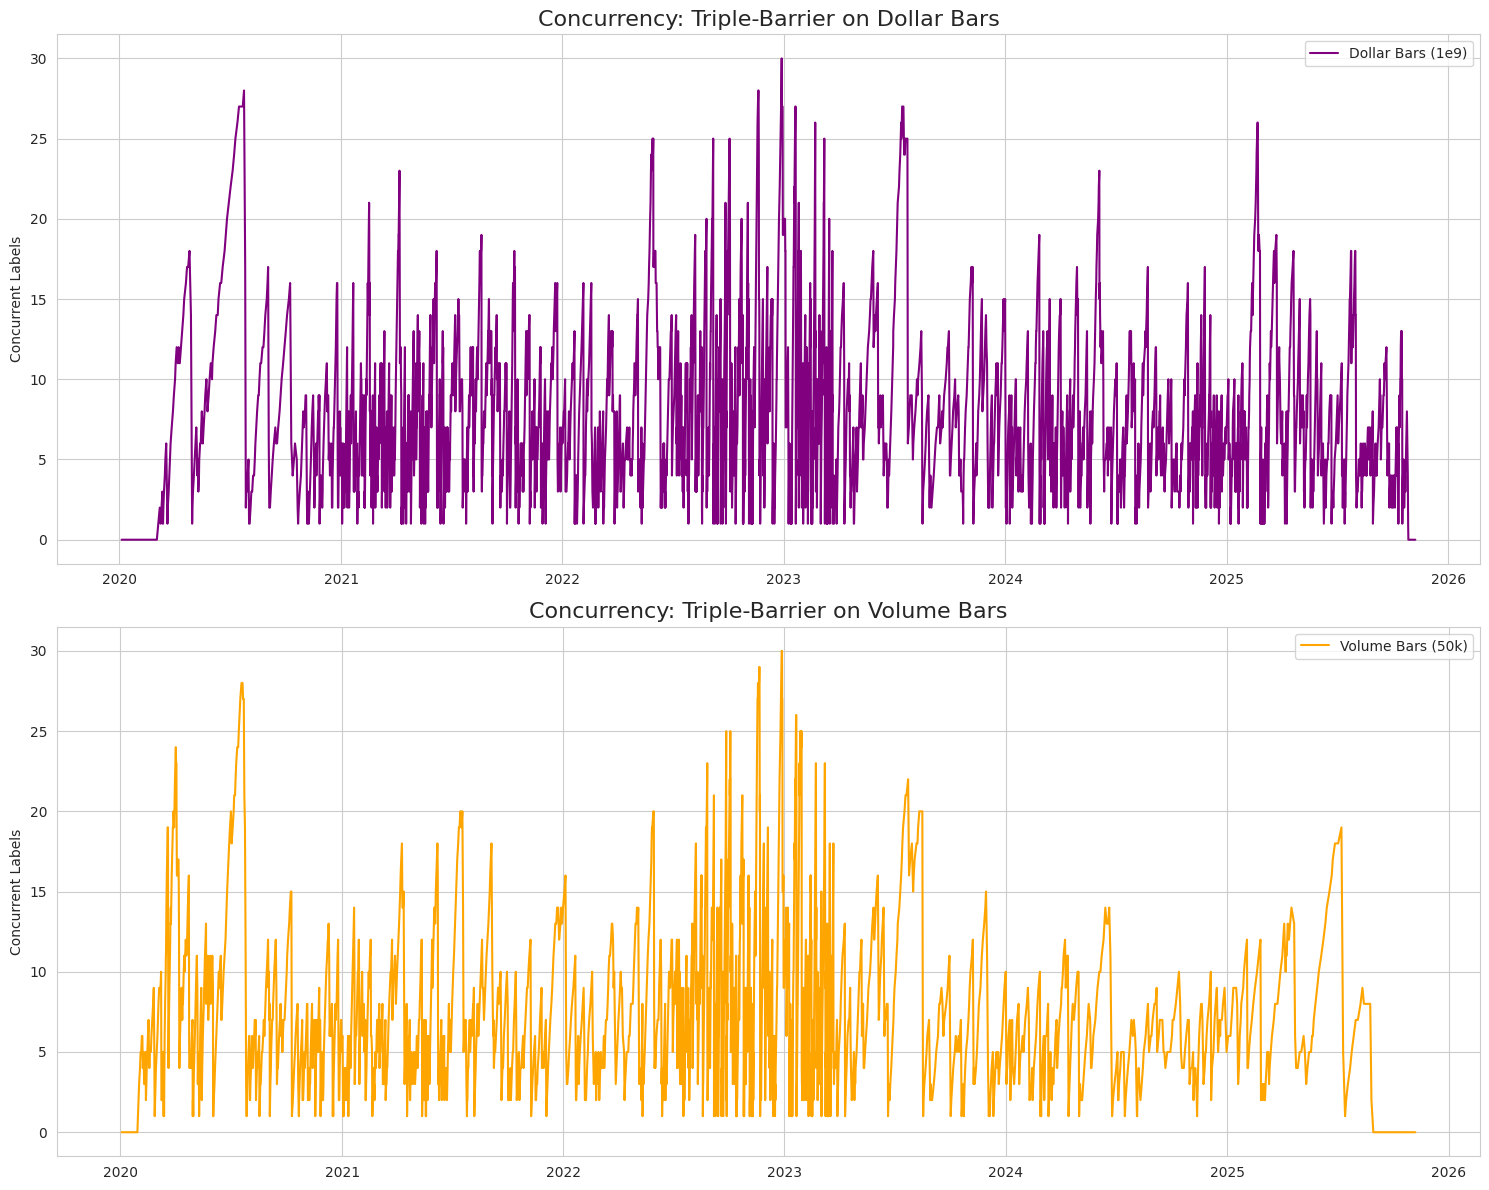


Alternative Bars Concurrency Stats:
       Dollar Bars  Volume Bars
count  4590.000000  2956.000000
mean      7.643355     7.767930
std       5.047069     5.474717
min       0.000000     0.000000
25%       4.000000     4.000000
50%       6.000000     6.000000
75%      10.000000    10.000000
max      30.000000    30.000000


In [ ]:
# 3. Compute Concurrency
print("Computing concurrency...")
concurrency_dollar = count_concurrent_labels(dollar_labels["event_end_time"], dollar_close.index)
concurrency_volume = count_concurrent_labels(volume_labels["event_end_time"], volume_close.index)

# 4. Visualize
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=False)

# Dollar Bars
axes[0].plot(concurrency_dollar, label=f"Dollar Bars (1e9)", color="purple")
axes[0].set_title("Concurrency: Triple-Barrier on Dollar Bars", fontsize=16)
axes[0].set_ylabel("Concurrent Labels")
axes[0].legend()
axes[0].grid(True)

# Volume Bars
axes[1].plot(concurrency_volume, label=f"Volume Bars (50k)", color="orange")
axes[1].set_title("Concurrency: Triple-Barrier on Volume Bars", fontsize=16)
axes[1].set_ylabel("Concurrent Labels")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\nAlternative Bars Concurrency Stats:")
concurrency_stats_alt = pd.DataFrame({
    "Dollar Bars": concurrency_dollar.describe(),
    "Volume Bars": concurrency_volume.describe()
})
print(concurrency_stats_alt)